In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from aggregation import Aggregator, get_subject_image, get_box_edges
from astropy.io import ascii
from astropy.table import Table
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from scipy.ndimage import gaussian_filter
from shapely.geometry import Polygon, Point
plt.style.use('default')

In [2]:
aggregator = Aggregator('reductions/point_reducer_hdbscan_box_the_jets.csv', 'reductions/shape_reducer_hdbscan_box_the_jets.csv')

In [3]:
subject = 70446508

In [4]:
frames_orig = [np.asarray(get_subject_image(subject, i), dtype=float)/255. for i in range(15)]

print([frame.shape for frame in frames_orig])

[(1440, 1920, 4), (1440, 1920, 4), (1440, 1920, 4), (1440, 1920, 4), (1440, 1920, 4), (1440, 1920, 4), (1440, 1920, 4), (1440, 1920, 4), (1440, 1920, 4), (1440, 1920, 4), (1440, 1920, 4), (1440, 1920, 4), (1440, 1920, 4), (1440, 1920, 4), (1440, 1920, 4)]


In [12]:
frames = np.array(frames_orig)

In [16]:
img_mean = np.mean([np.mean(frame[(frame.mean(axis=-1)<1.)&(frame.mean(axis=-1)>0.)]) for frame in frames_orig])
print(img_mean)

0.5150319179746438


In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ims = []
for i in range(len(frames)):
    frame = frames_orig[i]
    frames[i] = np.clip(frame*img_mean/np.mean(frame[(frame.mean(axis=-1)<1.)&(frame.mean(axis=-1)>0.)]), 0, 1)
    im = ax.imshow(frames[i][100:-10,200:-300], animated=True)
    ax.axis('off')
    ims.append([im])
plt.tight_layout()
ani = animation.ArtistAnimation(fig, ims, interval=500, blit=True, repeat_delay=1000)
plt.close()

In [18]:
HTML(ani.to_html5_video())

In [19]:
import cv2
import scipy.misc

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5), sharex=True, sharey=True)
ims = []

prvs = np.mean(frames[0],axis=-1)*255
prvs = prvs.astype(np.int8)

hsv = np.zeros((*frames[0].shape[:2],3), dtype=np.float32)
hsv[...,1] = 1

uu = np.zeros((14, *frames[0].shape[:2]))
vv = np.zeros((14, *frames[0].shape[:2]))

for i in range(14):
#     diff = frames[i+1][:,:,0] - frames[i][:,:,0]
#     curr = cv2.cvtColor(frames[i+1].astype(np.float32)[:,:,:3],cv2.COLOR_RGB2GRAY)
    curr = np.mean(frames[i+1],axis=-1)*255
    curr = curr.astype(np.int8)
    
    flow = cv2.calcOpticalFlowFarneback(prvs,curr, None, 0.5, 3, 3, 5, 7, 1.2, 0)
    
    u = gaussian_filter(flow[...,0],10)
    v = gaussian_filter(flow[...,1],10)
    
    uu[i,:] = u
    vv[i,:] = v
    
    mag = np.sqrt(u**2. + v**2.)
    ang = np.arctan2(v, u)
    ang[ang<0] += 2.*np.pi

    hsv[...,0] = ang*180/np.pi
    hsv[...,2] = mag/np.percentile(mag.flatten(), 99)#cv2.normalize(np.abs(mag),None,0,1,cv2.NORM_MINMAX)
    rgb = np.clip(cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB), 0, 1)
    
#     print(mag.min(), mag.max(), rgb.min(), rgb.max())

    im1 = ax2.imshow(rgb[100:-10,200:-300])
    im2 = ax1.imshow(frames[i+1][100:-10,200:-300])
    
    ax1.axis('off')
    ax2.axis('off')
    ims.append([im1,im2])
    
    prvs = curr
    
    
plt.tight_layout()
ani = animation.ArtistAnimation(fig, ims, interval=500, blit=True, repeat_delay=1000)
plt.close()

0.0 16.544255432082444


ValueError: The rows of 'x' must be equal

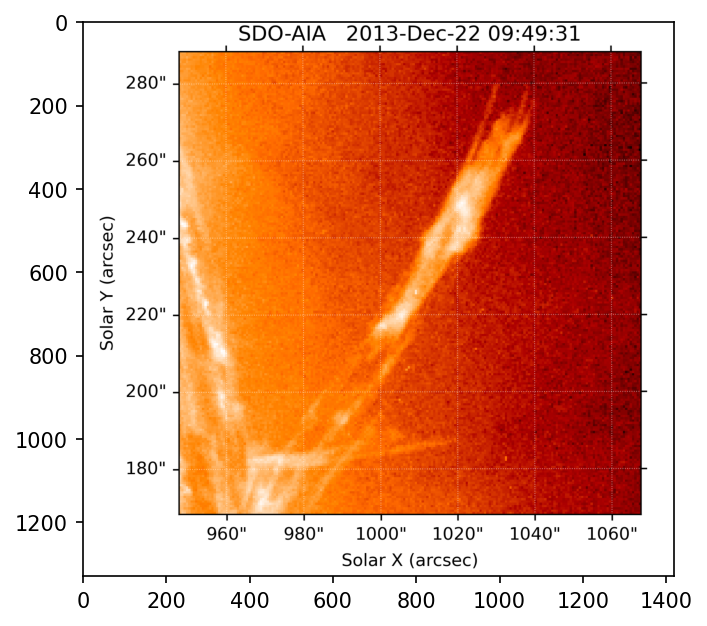

In [37]:
u = np.median(uu, axis=0)
v = np.median(vv, axis=0)

du = np.std(uu, axis=0)
dv = np.std(vv, axis=0)

ny, nx, _ = frames[0].shape

y, x = np.mgrid[:ny,:nx]

dmag = np.sqrt(dv**2. + dv**2.)
mag  = np.sqrt(u**2. + v**2.)

u[dmag>2.5*mag] = 0.
v[dmag>2.5*mag] = 0.

mag  = np.sqrt(u**2. + v**2.)
ang  = np.arctan2(v, u)
ang[ang<0] += 2.*np.pi

print(mag.min(), mag.max())

hsv[...,0] = ang*180/np.pi
hsv[...,2] = mag/np.percentile(mag.flatten(), 99)#cv2.normalize(np.abs(mag),None,0,1,cv2.NORM_MINMAX)
rgb = np.clip(cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB), 0, 1)

fig, ax1 = plt.subplots(1,1, sharex=True, sharey=True, dpi=150)

ax1.imshow(get_subject_image(subject, frame=7)[100:-10,200:-300])
ax1.streamplot(x, y, u, v, density=5.)
# ax2.imshow(rgb[100:-10,200:-300])
# plt.contour(dmag, vmin=0, vmax=25)
ax1.axis('off')
# ax2.axis('off')
plt.tight_layout()
plt.show()


In [22]:
HTML(ani.to_html5_video())

In [23]:
import hdbscan

In [24]:
points = np.array(np.where(mag>0.5)).T

data = np.zeros((len(points), 3))

In [25]:
for i, point in enumerate(points):
    y, x = point
    data[i,:] = [x, y, ang[y,x]]

In [26]:
plt.scatter(data[:,0], data[:,1], 0.1, c=data[:,2], cmap='jet')
plt.show()

In [27]:
clusterer = hdbscan.HDBSCAN(min_samples=5, min_cluster_size=5, cluster_selection_epsilon=0.1, allow_single_cluster=True).fit(data)

In [28]:
plt.scatter(data[:,0], data[:,1], 0.1, c=clusterer.labels_, cmap='jet')

In [29]:
HTML(ani.to_html5_video())

In [30]:
boxes = aggregator.find_unique_jets(subject)

/tmp/ipykernel_1601513/3965755405.py:26: UserWarning: The following kwargs were not used by contour: 'color'
  ax.contour(img_mask, vmin=0.5, vmax=1.5, color='k')


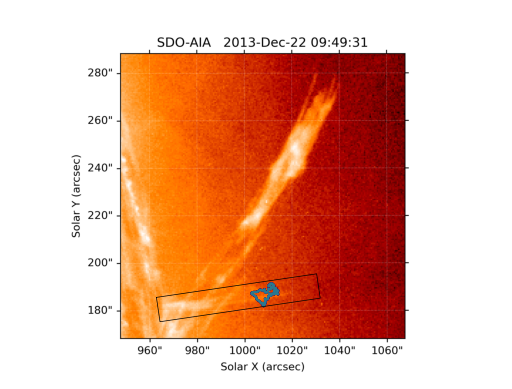

In [31]:
labels = clusterer.labels_
for i, box in enumerate(boxes):
    cluster_in = []
    for cluster in np.unique(labels):
        points = data[labels==cluster,:]
        point_in_mask = np.zeros(len(points), dtype=bool)
        for k, point in enumerate(points):
            if box.contains(Point(point[0], point[1])):
                point_in_mask[k] = True
                
        if sum(point_in_mask) > 0.9*len(points):
            cluster_in.append(cluster)
        
    fig, ax = plt.subplots(1,1)
    img = get_subject_image(subject,7)
    ax.imshow(img)
    img_mask = np.zeros(img.shape[:2])
    npoints = []
    for cluster in cluster_in:
        npoints.append(len(data[labels==cluster,:]))
    best_cluster = np.argmax(npoints)
    
    points = data[labels==cluster_in[best_cluster],:]
    for point in points:
        img_mask[int(point[1]), int(point[0])] = 1
    ax.contour(img_mask, vmin=0.5, vmax=1.5, color='k')
    ax.plot(*box.exterior.xy, 'k-', linewidth=0.5)
#     ax.scatter(points[:,0], points[:,1], 0.05)
    ax.axis('off')
    plt.show()